<a href="https://colab.research.google.com/github/subratamondal1/Bird-525-Species-Detector-/blob/main/birds_525_species_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [BIRDS 525 SPECIES DETECTOR](https://huggingface.co/spaces/iamsubrata/birds-525-species-detector) - IMAGE CLASSIFICATION WITH TRANSFER LEARNING
---

## ResNet50 and Transfer Learning

* **ResNet50** is a powerful deep learning model that has achieved state-of-the-art performance on many computer vision tasks. It is a **convolutional neural network (CNN)** with **50 layers** and has been **trained on the ImageNet dataset**, which contains over **1 million images** and **1000 classes**.
* **Transfer learning** is a machine learning technique that involves using a pre-trained model as a starting point for training a new model on a different dataset. This technique is useful in scenarios where the **new dataset is small**, and training a new model from scratch may lead to overfitting.
* **ResNet50** can be used for transfer learning by removing the last layer of the pre-trained model and adding a new output layer that is specific to the new task. The pre-trained weights of the ResNet50 model will be fine-tuned during training to fit the new dataset.
* Transfer learning with ResNet50 is a powerful technique that can be used to train accurate models with relatively small datasets. It is a popular technique used in many machine learning and computer vision applications.

**Benefits of using ResNet50 for transfer learning**

* **Efficiency:** Transfer learning can save a significant amount of time and computational resources, as it does not require the model to be trained from scratch.
* **Accuracy:** Transfer learning can help to improve the accuracy of models trained on small datasets.
* **Versatility:** Transfer learning can be used to train models for a wide variety of tasks, including image classification, object detection, and segmentation.

In [ ]:
# NVIDIA System Management Interface (SMI)
! nvidia-smi

Sat Oct  7 05:14:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

# 1. USING FREEZED MODEL
* Pretrained Model is **RESNET50**

## 1.1. Load Data

- **Dataset Size:** 525 bird species.
- **Images:** 84,635 training images, 2,625 test images (5 per species), and 2,625 validation images (5 per species).
- **Image Dimensions:** 224x224x3 JPG format.
- **Data Structure:** Convenient subdirectories for each species.
- **Additional File:** `birds.csv` contains file paths, class labels, and more.

**Dataset Quality:**
- Cleaned to remove duplicate and low-quality images.
- Each image features a single bird taking up at least 50% of pixels.
- Original images, no augmentation.

**File Naming:**
- Sequential numbering, e.g., "001.jpg," "002.jpg" for training.
- Test and validation images: "1.jpg" to "5.jpg."

**Note:** Training set not balanced but has ≥130 images per species.

In [ ]:
# Import Fastai libraries
import fastai
from fastai.vision.all import *  # Comprehensive computer vision library
from fastcore.foundation import L  # Foundational utilities
from fastcore.xtras import Path  # Extends functionality for Path objects
from fastai.callback.fp16 import to_fp16  # Enables mixed-precision training
from fastai.callback.schedule import fit_one_cycle, lr_find  # Training schedule utilities
from fastai.data.block import CategoryBlock, DataBlock  # Define data block components
from fastai.data.transforms import (  # Data transformation functions
    get_image_files, Normalize, RandomSplitter, parent_label
)
from fastai.interpret import ClassificationInterpretation  # Interpret classification results
from fastai.learner import Learner  # Main class for model training
from fastai.vision.augment import aug_transforms, RandomResizedCrop  # Image augmentation
from fastai.vision.core import imagenet_stats  # ImageNet dataset statistics
from fastai.vision.data import ImageBlock  # Define handling of images
from fastai.vision.learner import cnn_learner  # Create CNN learners
from fastai.vision.utils import download_images, verify_images  # Image-related utilities
import warnings

# Use filterwarnings to suppress specific warnings
warnings.filterwarnings('ignore')  # This suppresses all warnings

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
from fastai.data.transforms import get_image_files # to retrieve image files

path = Path("/kaggle/input/100-bird-species")  # Main path
train_path = path / "train"  # Training data path
val_path = path / "valid"  # Validation data path
test_path = path / "test"  # Test data path

# Define a function to get the list of image files and labels
def get_items(path):
    return get_image_files(path)  # Get a list of image files in the specified path

# Define a function to get the label from the folder name
def label_func(x):
    return x.parent.name  # Extract the label from the parent folder name

## 1.2. Data Preparation

**`aug_transforms`**

- This function is used to create a list of data augmentation transforms that can be applied to images.
- **Data augmentation** is a technique used to **artificially increase the size** of a training dataset by applying random transformations to the images, such as rotation, flipping, and resizing. This helps to improve the model's ability to generalize and perform better on unseen data.


**`item_tfms`**

**Item transforms** are applied to each individual image in the dataset before they are batched. This is typically used for operations that are *computationally expensive to apply to batches* of images, such as **resizing** and **cropping**.

- Images resized to a consistent width of 460 pixels.

**`batch_tfms`**

**Batch transforms** are applied to batches of images after they have been formed. This is typically used for operations that are more *efficient to apply to batches of images*, such as **normalizing the pixel values** and **adding noise**.

- Images resized to 224x224 pixels with a minimum scaling of 75%.
    * This means that the images in batches will be resized to a width of 224 pixels, and the height will be scaled accordingly. If the original image is smaller than 224 pixels wide, it will be scaled up to 224 pixels wide. If the original image is larger than 224 pixels wide, it will be scaled down to 224 pixels wide, but the minimum scale of 75% ensures that the image is not scaled down too much.

- The scaling part of the batch transforms is important for two reasons:
    * It ensures that all of the images in the batch are the same size. This is necessary for training machine learning models, as the models expect to receive inputs of the same size.
    * It helps to improve the performance of the machine learning models. By scaling the images to a smaller size, we can reduce the amount of memory and computation that is required to train the models. We can also reduce the risk of overfitting, as the models will be less likely to learn to fit the specific features of the training images.

The scaling part of the batch transforms is a common data augmentation technique that is used in machine learning. It is a simple but effective way to improve the performance of machine learning models.

In [ ]:
# Import augmentation transforms
from fastai.vision.augment import aug_transforms

# Item transforms: Resize images to 460 pixels width.
item_tfms = [Resize(460)]

# Batch transforms: Resize to 224 pixels with min 75% scaling and apply other augmentations.
batch_tfms = [*aug_transforms(min_scale=0.75, size=224)]

Also these transformations ensure data consistency and introduce variability, preparing the dataset for model training.

## 1.3. Create DataLoader

**`DataBlock`**

A DataBlock in FastAI is a container for defining the data structure and transformations for a dataset. It takes the following arguments:

* **blocks:** A tuple of blocks, where each block represents a different type of data. For example, a dataset of images and labels might have two blocks: one for the images and one for the labels.
    * The **ImageBlock** is the input block, which represents the image data.
    * The **CategoryBlock** is the output block, which represents the categorical label data.
* **get_items:** A function that takes the path to the dataset and returns a list of items. For example, the `get_image_files` function returns a list of all the image files in a directory.
* **splitter:** A callable that takes a list of items and returns a tuple of two lists: one for the train set and one for the validation set. FastAI provides a number of pre-built splitters, such as `GrandparentSplitter` and `RandomSplitter`.
* **get_y:** A function that takes an item and returns the label for that item. For example, the `parent_label` function returns the name of the parent directory of an image file.

**`dataloaders`**

A Dataloader in FastAI is an **iterator** that **returns batches of data**. It is created using the `dataloaders` method of a DataBlock. The `dataloaders` method takes the `path` to the dataset and the `batch size (bs)` as arguments.

DataBlocks and Dataloaders are powerful tools for managing and loading data in FastAI. They make it easy to define and apply complex data transformations, and they provide a number of other features that make training machine learning models more efficient and effective.

Here, is how we apply them ...

In [ ]:
from fastai.data.block import DataBlock, CategoryBlock
from fastai.vision.data import ImageBlock

dblock = DataBlock(
    # blocks = (input, output)
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name="train",valid_name='test'),
    get_y=parent_label,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)


# Create Fastai DataLoaders using the DataBlock and path to data
fastai_dls = dblock.dataloaders(path, bs=32, device=torch.device('cuda'))

In [ ]:
# Now, let's check the Classes aka Labels
print(len(fastai_dls.vocab))
fastai_dls.vocab

525


['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN DIPPER', 'AMERICAN FLAMINGO', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'AMERICAN ROBIN', 'AMERICAN WIGEON', 'AMETHYST WOODSTAR', 'ANDEAN GOOSE', 'ANDEAN LAPWING', 'ANDEAN SISKIN', 'ANHINGA', 'ANIANIAU', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ANTILLEAN EUPHONIA', 'APAPANE', 'APOSTLEBIRD', 'ARARIPE MANAKIN', 'ASHY STORM PETREL', 'ASHY THRUSHBIRD', 'ASIAN CRESTED IBIS', 'ASIAN DOLLARD BIRD', 'ASIAN GREEN BEE EATER', 'ASIAN OPENBILL STORK', 'AUCKLAND SHAQ', 'AUSTRAL CANASTERO', 'AUSTRALASIAN FIGBIRD', 'AVADAVAT', 'AZARAS SPINETAIL', 'AZURE BREASTED PITTA', 'AZURE JAY', 'AZURE TANAGER', '

Good! Let's take a look at some of our pictures then.

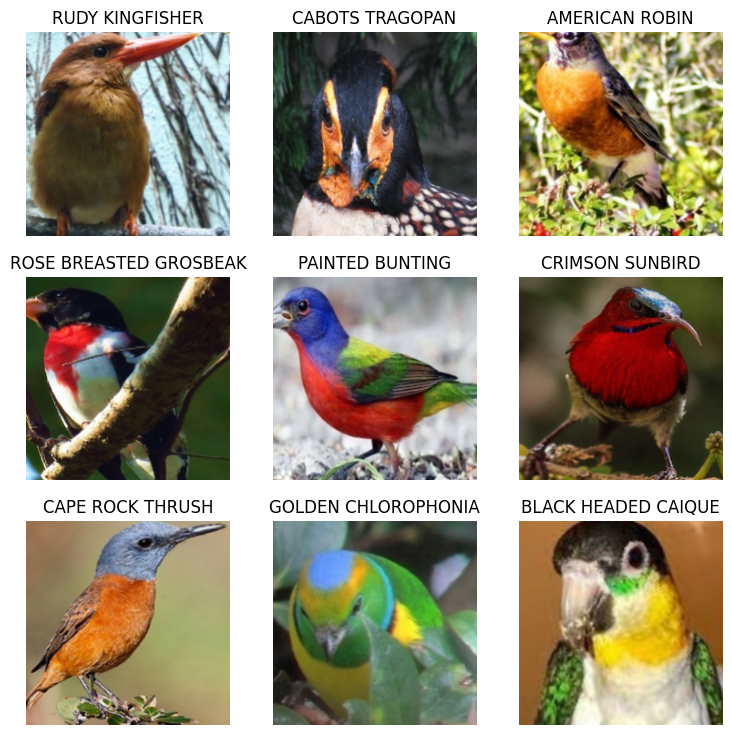

In [ ]:
# Show a batch of data
fastai_dls.show_batch()

In [ ]:
print(fastai_dls.train_ds)
print(fastai_dls.valid_ds)

# Check if the total classes in train and valid set are same or not
len(fastai_dls.train_ds.vocab) == len(fastai_dls.valid_ds.vocab)

(#84635) [(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185))...]
(#2625) [(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(185)),(PILImage mode=RGB size=224x224, TensorCategory(75)),(PILImage mode=RGB size=224x224, TensorCategory(75)),(PILImage mode=RGB size=224x224, TensorCategory(75)),(PILImag

True

In [ ]:
# Prints all of the labels in the validation set that are not in the training set
for label in fastai_dls.valid_ds.vocab:
    if label not in fastai_dls.train_ds.vocab:
        print(label)

## 1.4. Model and Learning Rate

**Pre-trained Model Configuration:**
- Imported pre-trained ResNet models (resnet34 and resnet50) from torchvision.
- Created a vision learner using the Fastai library with the ResNet-50 architecture.
- Enabled the use of pretrained weights and specified evaluation metrics, including accuracy and error rate.
- Enabled mixed-precision training using `to_fp16()` for enhanced training efficiency.

**Finding Learning Rate:**
- Utilized the `lr_find()` method to determine an optimal learning rate.
- Discovered a suitable learning rate range (`lr`) for model training, set as `slice(1e-4, 5e-3)`.

This section highlights the model configuration, including the choice of architecture, pretrained weights, and learning rate discovery, ensuring an effective setup for model training and evaluation.


FastAI learner for image classification using the ResNet50 model. The learner is pretrained on the ImageNet dataset, which means that the model weights have already been trained on a large dataset of images. This can help the model to learn to classify images more accurately, even if the training set is small.

* `vision_learner()` is a FastAI function that creates a learner for image classification. It takes the following arguments:
    * `dls`: The FastAI DataLoaders object for the training and validation data.
    * `arch`: The model architecture. In this case, we are using the ResNet50 model.
    * `pretrained`: A boolean value indicating whether to use the pretrained model weights.
    * `metrics`: A list of metrics to track during training and validation. In this case, we are tracking the accuracy and error rate.
* `to_fp16()` converts the model to half-precision floating-point format. This can help to reduce the memory and computation requirements of the model, especially when training on large datasets.

In [ ]:
from torchvision.models.resnet import resnet34, resnet50

learn = vision_learner(
    dls = fastai_dls,
    arch = resnet50,
    pretrained=True,
    wd=0.01,
    metrics=[accuracy, error_rate]
).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s] 


In [ ]:
learn.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     32 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                        

SuggestedLRs(valley=0.001737800776027143)

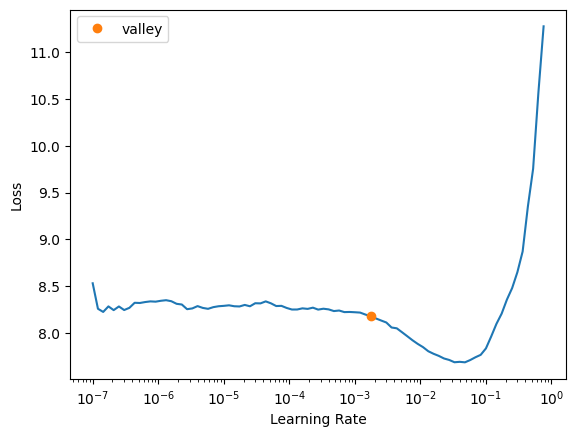

In [ ]:
# Find the optimal learning rate using the learning rate finder.
learn.lr_find()

**Dynamic learning rate** range: Starts low and increases gradually during training.

In [ ]:
lr = slice(1e-4, 5e-3)

## 1.5. Train Model

**Model Performance with Resnet50 (Freezed Layers)**

| Epoch | Train Loss | Valid Loss | Accuracy | Error Rate | Time   |
|-------|------------|------------|----------|------------|--------|
| 0     | 1.2802     | 0.4474     | 0.8705   | 0.1295     | 13:50  |
| 1     | 0.7865     | 0.1838     | 0.9482   | 0.0518     | 11:06  |
| 2     | 0.4920     | 0.1074     | 0.9695   | 0.0305     | 11:17  |
| 3     | 0.3435     | 0.0671     | 0.9844   | 0.0156     | 10:44  |
| 4     | 0.2979     | 0.0590     | 0.9859   | 0.0141     | 11:12  |

**Model Training:**
- The model was trained for 5 epochs using a one-cycle learning rate policy with the specified learning rate range.
- The training results demonstrate the model's impressive performance, achieving high accuracy and low error rates.

**Model Preservation:**
- Saved the trained model with the name 'model1_freezed' for future use.
- This step ensures that the model's architecture and learned weights are preserved and can be easily loaded and deployed for various tasks.

This section provides an overview of the model's training performance, including training and validation losses, accuracy, and error rates. It also emphasizes the importance of preserving the trained model for future use.

The **`learn.fit_one_cycle()`** method in FastAI is a training method that uses a cyclical learning rate schedule. This means that the learning rate is gradually increased during the first half of the training process and then gradually decreased during the second half.

In [ ]:
from fastai.callback.tracker import EarlyStoppingCallback

# Train the learner using the fit_one_cycle() method with L2 regularization and early stopping
learn.fit_one_cycle(
    n_epoch = 3,
    lr_max=lr,
    cbs=[EarlyStoppingCallback(monitor='valid_loss')]
)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.169282,0.364764,0.901333,0.098667,14:01
1,0.663994,0.126701,0.968000,0.032000,12:08
2,0.442469,0.077037,0.977143,0.022857,13:43


In [ ]:
val_loss, acc, err = learn.validate()

print(f"Val Loss: {val_loss}")
print(f"Accuracy: {acc}")
print(f"Error: {err}")

Val Loss: 0.07703705132007599
Accuracy: 0.977142870426178
Error: 0.022857142612338066


## 1.6. Model Interpretation

In [ ]:
# Model Interpretation
# Import the ClassificationInterpretation class from fastai and create an instance 'interp' to interpret model results.

interp = ClassificationInterpretation.from_learner(learn)

# Calculate and store prediction losses and their corresponding indices.
losses, idxs = interp.top_losses()

# Check if the number of validation dataset samples, losses, and indices are equal.
print(len(fastai_dls.valid_ds) == len(losses) == len(idxs))

# Classification Report
# Print a classification report summarizing model performance.
interp.print_classification_report()

True


                               precision    recall  f1-score   support

              ABBOTTS BABBLER       1.00      1.00      1.00         5
                ABBOTTS BOOBY       1.00      0.80      0.89         5
   ABYSSINIAN GROUND HORNBILL       1.00      1.00      1.00         5
        AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
       AFRICAN EMERALD CUCKOO       1.00      1.00      1.00         5
            AFRICAN FIREFINCH       1.00      1.00      1.00         5
       AFRICAN OYSTER CATCHER       1.00      1.00      1.00         5
        AFRICAN PIED HORNBILL       1.00      1.00      1.00         5
          AFRICAN PYGMY GOOSE       1.00      1.00      1.00         5
                    ALBATROSS       1.00      1.00      1.00         5
               ALBERTS TOWHEE       1.00      1.00      1.00         5
         ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
                ALPINE CHOUGH       0.71      1.00      0.83         5
     

In [ ]:
# Most Confused
interp.most_confused()

In [ ]:
# Plot top lossses
interp.plot_top_losses(k=9, figsize=(15,10)) # pred/actual/loss/prob

In [ ]:
# Plot Confusion Matric
interp.plot_confusion_matrix(figsize=(16,16), dpi=60)

# 2. Using Unfreezed Model to Fine Tune

## 2.1. Unfreeze the Model  

In [ ]:
# Unfreeze the model to allow all layers to be trained
learn.unfreeze()

learn.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     32 x 256 x 56 x 56  
Conv2d                                    16384      True      
BatchNorm2d                        

## 2.2. Find Learning Rate

SuggestedLRs(valley=0.0004786300996784121)

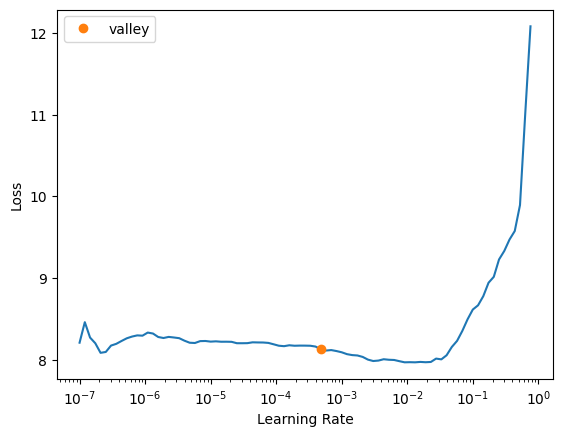

In [ ]:
# Find the optimal learning rates for fine-tuning
learn.lr_find()

In [ ]:
# Set learning rate range (slice) for fine-tuning
lr = slice(1e-4, 1e-3)

## 2.3. Train & Save Model

In [ ]:
# Fine Tune the Model using the fit_one_cycle() method with L2 regularization and early stopping
learn.fit_one_cycle(
    n_epoch = 3,
    lr_max=lr,
    cbs=[EarlyStoppingCallback(monitor='valid_loss')]
)

# Save the fine-tuned model with the name 'model2_unfreezed'
learn.save('model2_unfreezed')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.278963,0.481954,0.874286,0.125714,19:17
1,0.528779,0.108010,0.972190,0.027810,13:56
2,0.342900,0.046998,0.988952,0.011048,13:02


Path('models/model2_unfreezed.pth')

In [ ]:
val_loss, acc, err = learn.validate()

print(f"Val Loss: {val_loss}")
print(f"Accuracy: {acc}")
print(f"Error: {err}")

Val Loss: 0.04699791595339775
Accuracy: 0.9889523983001709
Error: 0.01104761939495802


## 2.4. Model Interpretation

In [ ]:
# Model Interpretation
from fastai.interpret import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

print(len(fastai_dls.valid_ds)==len(losses)==len(idxs))

# Classification Report
interp.print_classification_report()

True


                               precision    recall  f1-score   support

              ABBOTTS BABBLER       0.00      0.00      0.00         5
                ABBOTTS BOOBY       0.00      0.00      0.00         5
   ABYSSINIAN GROUND HORNBILL       0.00      0.00      0.00         5
        AFRICAN CROWNED CRANE       0.00      0.00      0.00         5
       AFRICAN EMERALD CUCKOO       0.00      0.00      0.00         5
            AFRICAN FIREFINCH       0.00      0.00      0.00         5
       AFRICAN OYSTER CATCHER       0.00      0.00      0.00         5
        AFRICAN PIED HORNBILL       0.00      0.00      0.00         5
          AFRICAN PYGMY GOOSE       0.00      0.00      0.00         5
                    ALBATROSS       0.00      0.00      0.00         5
               ALBERTS TOWHEE       0.00      0.00      0.00         5
         ALEXANDRINE PARAKEET       0.00      0.00      0.00         5
                ALPINE CHOUGH       0.00      0.00      0.00         5
     

In [ ]:
# Most Confused
interp.most_confused()

## 2.5. Model Interpretation

In [ ]:
learn.load('model2_unfreezed');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(3, figsize=(9,9))

## 2.6. Model Inference

In [ ]:
# Download Image
!wget -O out.jpg "https://th.bing.com/th/id/OIP.WZoNdVGy2N28WT1uWGP05QHaLH?w=127&h=190&c=7&r=0&o=5&dpr=2&pid=1.7"

--2023-10-07 05:17:52--  https://th.bing.com/th/id/OIP.WZoNdVGy2N28WT1uWGP05QHaLH?w=127&h=190&c=7&r=0&o=5&dpr=2&pid=1.7
Resolving th.bing.com (th.bing.com)... 23.218.93.177, 23.218.93.178, 2600:1402:b800:36::172f:cc95, ...
Connecting to th.bing.com (th.bing.com)|23.218.93.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22688 (22K) [image/jpeg]
Saving to: ‘out.jpg’

out.jpg             100%[===================>]  22.16K  --.-KB/s    in 0.001s  

2023-10-07 05:17:52 (15.0 MB/s) - ‘out.jpg’ saved [22688/22688]



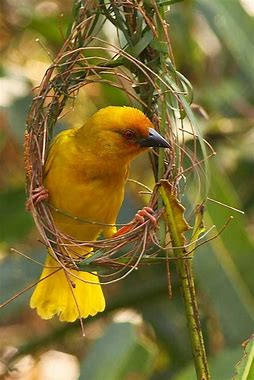

In [ ]:
# Display the image
from PIL import Image
image_path = "/kaggle/working/out.jpg"
image = Image.open("/kaggle/working/out.jpg")
image

In [ ]:
# Inference
learn.load('model2_unfreezed')
output = learn.predict(image)
output[0]

'EASTERN GOLDEN WEAVER'

## 2.7. Model Export

In [ ]:
# We will export all the required files and variables that will be necessary for making inference

# Export the fastai learner (model) for inference
learn.export("pets_breed_learner.pkl")

# Export the Pets Breed Vocabular (Class Names)
vocab = dls.vocab

# Save the vocab to the pickle file
with open("pets_breed_vocab.pkl", "wb") as f:
    pickle.dump(obj=vocab, file=f)